In [1]:
import numpy as np
import scipy.io as scio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import seaborn as sns
import cartopy
import matplotlib
from cartopy.util import add_cyclic_point

def central_transform(data2D):
    data2D_new=np.full((360,180),np.nan)
    data2D_new[180:361,:]=data2D[20:200,:]
    data2D_new[0:160,:]=data2D[200:360,:]
    data2D_new[160:180,:]=data2D[0:20,:]
    return data2D_new

def central_transform_2degree(data2D):
    data2D_new=np.full((180,91),np.nan)
    data2D_new[90:181,:]=data2D[10:100,:]
    data2D_new[0:80,:]=data2D[100:180,:]
    data2D_new[80:90,:]=data2D[0:10,:]
    return data2D_new

def reduced_dimension(variable_2D_lon_lat,times=4):
    signal_divide_noise1_reduced = variable_2D_lon_lat.copy()
    for i in range(360):
        for j in range(180):
            if i % times != 0 or j % times != 0:
                signal_divide_noise1_reduced[i, j] = np.nan
    return signal_divide_noise1_reduced

C:\Users\dell\.conda\envs\myenv2\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
######### load data
data=scio.loadmat('./Input_data/magnitude_upper2001000_T.mat') #load latitude and lognitude array
lon=data['lon'][:]
lat=data['lat'][:]

### load the magnitude, intensity, and duration data to determine the medium and high exposure regions
data=np.load('./Input_data/Magnitude_low_medium_high_flag_upper200.npz')
magnitude_200_T_flag = data['magnitude_200_T_flag']
magnitude_200_S_flag = data['magnitude_200_S_flag']
magnitude_200_DO_flag = data['magnitude_200_DO_flag']
magnitude_overlap_200_T_S_flag = data['magnitude_overlap_200_T_S_flag']
magnitude_overlap_200_T_DO_flag = data['magnitude_overlap_200_T_DO_flag']
magnitude_overlap_200_T_S_DO_flag = data['magnitude_overlap_200_T_S_DO_flag']

data=np.load('./Input_data/Intensity_low_medium_high_flag_upper200.npz')
intensity_200_T_flag = data['intensity_200_T_flag']
intensity_200_S_flag = data['intensity_200_S_flag']
intensity_200_DO_flag = data['intensity_200_DO_flag']
intensity_overlap_200_T_S_flag = data['intensity_overlap_T_S_flag']
intensity_overlap_200_T_DO_flag = data['intensity_overlap_T_DO_flag']
intensity_overlap_200_T_S_DO_flag = data['intensity_overlap_T_S_DO_flag']

data=np.load('./Input_data/Duration_low_medium_high_flag_upper200.npz')
duration_200_T_flag = data['duration_200_T_flag']
duration_200_S_flag = data['duration_200_S_flag']
duration_200_DO_flag = data['duration_200_DO_flag']
duration_overlap_200_T_S_flag = data['duration_overlap_200_T_S_flag']
duration_overlap_200_T_DO_flag = data['duration_overlap_200_T_DO_flag']
duration_overlap_200_T_S_DO_flag = data['duration_overlap_200_T_S_DO_flag']

### load mean total organic carbon export (mgC/m2/day) data (reference from Nowicki et al. 2022)
data=scio.loadmat('./Input_data/bio_pump_total_carbon_export.mat')
tot_ex=data['tot_ex'][:]
tot_ex=np.transpose(tot_ex)
tot_ex[:,0:10]=np.nan 
tot_ex[:,80:91]=np.nan
lon_2=data['lon_2'][:]
lon_2=np.transpose(lon_2)
lat_2=data['lat_2'][:]
lat_2=np.transpose(lat_2)

In [3]:
### define high/medium/low exposure for each variables
exposure_single_emergence_flag = np.full((360, 180),np.nan)
exposure_double_emergence_flag = np.full((360, 180),np.nan)
exposure_triple_emergence_flag = np.full((360, 180),np.nan)
for i in range(360):
    for j in range(180):
        if(~np.isnan(magnitude_200_T_flag[i,j])):
            data=np.array([magnitude_200_T_flag[i,j],intensity_200_T_flag[i,j],duration_200_T_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2): ### high exposure: at least two parameter shows 'high'=3
                exposure_single_emergence_flag[i,j]=1
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_single_emergence_flag[i,j]=1 #other cases: medium exposure

        if(~np.isnan(magnitude_200_S_flag[i,j])):
            data=np.array([magnitude_200_S_flag[i,j],intensity_200_S_flag[i,j],duration_200_S_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_single_emergence_flag[i,j]=1
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_single_emergence_flag[i,j]=1 #other cases: medium exposure

        if(~np.isnan(magnitude_200_DO_flag[i,j])):
            data=np.array([magnitude_200_DO_flag[i,j],intensity_200_DO_flag[i,j],duration_200_DO_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_single_emergence_flag[i,j]=1
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_single_emergence_flag[i,j]=1 #other cases: medium exposure
                
        if(~np.isnan(magnitude_overlap_200_T_S_flag[i,j])):
            data=np.array([magnitude_overlap_200_T_S_flag[i,j],intensity_overlap_200_T_S_flag[i,j],duration_overlap_200_T_S_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_double_emergence_flag[i,j]=2
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_double_emergence_flag[i,j]=2 #other cases: medium exposure
                
        if(~np.isnan(magnitude_overlap_200_T_DO_flag[i,j])):
            data=np.array([magnitude_overlap_200_T_DO_flag[i,j],intensity_overlap_200_T_DO_flag[i,j],duration_overlap_200_T_DO_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_double_emergence_flag[i,j]=2
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                pass
            else:
                exposure_double_emergence_flag[i,j]=2 #other cases: medium exposure
                
        if(~np.isnan(magnitude_overlap_200_T_S_DO_flag[i,j])):
            data=np.array([magnitude_overlap_200_T_S_DO_flag[i,j],intensity_overlap_200_T_S_DO_flag[i,j],duration_overlap_200_T_S_DO_flag[i,j]])
            if(np.all(np.isnan(data))):
                continue
            if(np.sum(data==3)>=2):
                exposure_triple_emergence_flag[i,j]=3
            elif(np.sum(data==1)>=2):  # low exposure: at least two parameter shows 'low'
                exposure_triple_emergence_flag[i,j]=0
            else:
                exposure_triple_emergence_flag[i,j]=3 #other cases: medium exposure

########## combine all single emergence
index=np.where(~np.isnan(exposure_triple_emergence_flag))
exposure_single_emergence_flag[index]=np.nan
index=np.where(~np.isnan(exposure_double_emergence_flag))
exposure_single_emergence_flag[index]=np.nan

exposure_double_emergence_flag_reduce=reduced_dimension(exposure_double_emergence_flag,times=3) # for friendly visualization purpose
exposure_triple_emergence_flag_reduce=reduced_dimension(exposure_triple_emergence_flag,times=2)

In [4]:
#### transform the data projection central longitude
exposure_single_emergence_flag=central_transform(exposure_single_emergence_flag)
exposure_double_emergence_flag=central_transform(exposure_double_emergence_flag)
exposure_triple_emergence_flag=central_transform(exposure_triple_emergence_flag)
exposure_double_emergence_flag_reduce=central_transform(exposure_double_emergence_flag_reduce)
exposure_triple_emergence_flag_reduce=central_transform(exposure_triple_emergence_flag_reduce)

exposure_single_emergence_flag, cycle_lon = add_cyclic_point(np.transpose(exposure_single_emergence_flag),np.transpose(lon)[0])
exposure_double_emergence_flag, cycle_lon = add_cyclic_point(np.transpose(exposure_double_emergence_flag),np.transpose(lon)[0])
exposure_triple_emergence_flag, cycle_lon = add_cyclic_point(np.transpose(exposure_triple_emergence_flag),np.transpose(lon)[0])
exposure_double_emergence_flag_reduce, cycle_lon = add_cyclic_point(np.transpose(exposure_double_emergence_flag_reduce),np.transpose(lon)[0])
exposure_triple_emergence_flag_reduce, cycle_lon = add_cyclic_point(np.transpose(exposure_triple_emergence_flag_reduce),np.transpose(lon)[0])

#### transform the data projection central longitude
tot_ex=central_transform_2degree(tot_ex)
tot_ex, cycle_lon_2 = add_cyclic_point(np.transpose(tot_ex),(lon_2)[0])

In [5]:
### set the colorbar
white=(1,1,1)

reds=sns.color_palette('Reds',6)
reds=[white,reds[0],reds[2]]
new_reds=matplotlib.colors.ListedColormap(reds,name='new_reds')  #only T 

whites=sns.color_palette('binary',6)
whites=[white,whites[1],whites[3]]
new_whites=matplotlib.colors.ListedColormap(whites,name='new_whites')  # only S 

purples=sns.color_palette('Purples_r',16)
purples=[white,purples[6],purples[0]]  
new_purples=matplotlib.colors.ListedColormap(purples,name='new_purples')  #### only DO 

oranges=sns.color_palette('YlOrBr',8)
oranges=[white,oranges[3],oranges[5]]
new_oranges=matplotlib.colors.ListedColormap(oranges,name='new_oranges')  #T+S  oranges

dark_green=sns.color_palette('YlGn_r',12)
dark_greens=[white,dark_green[3],dark_green[0]]  
new_dark_greens=matplotlib.colors.ListedColormap(dark_greens,name='new_dark_greens')  #T+S+DO  dark green

light_green=sns.color_palette('YlGn_r',12)
light_green=[white,light_green[8],light_green[6]]  
new_light_greens=matplotlib.colors.ListedColormap(light_green,name='new_light_greens')  #T+DO  light green

C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)
C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


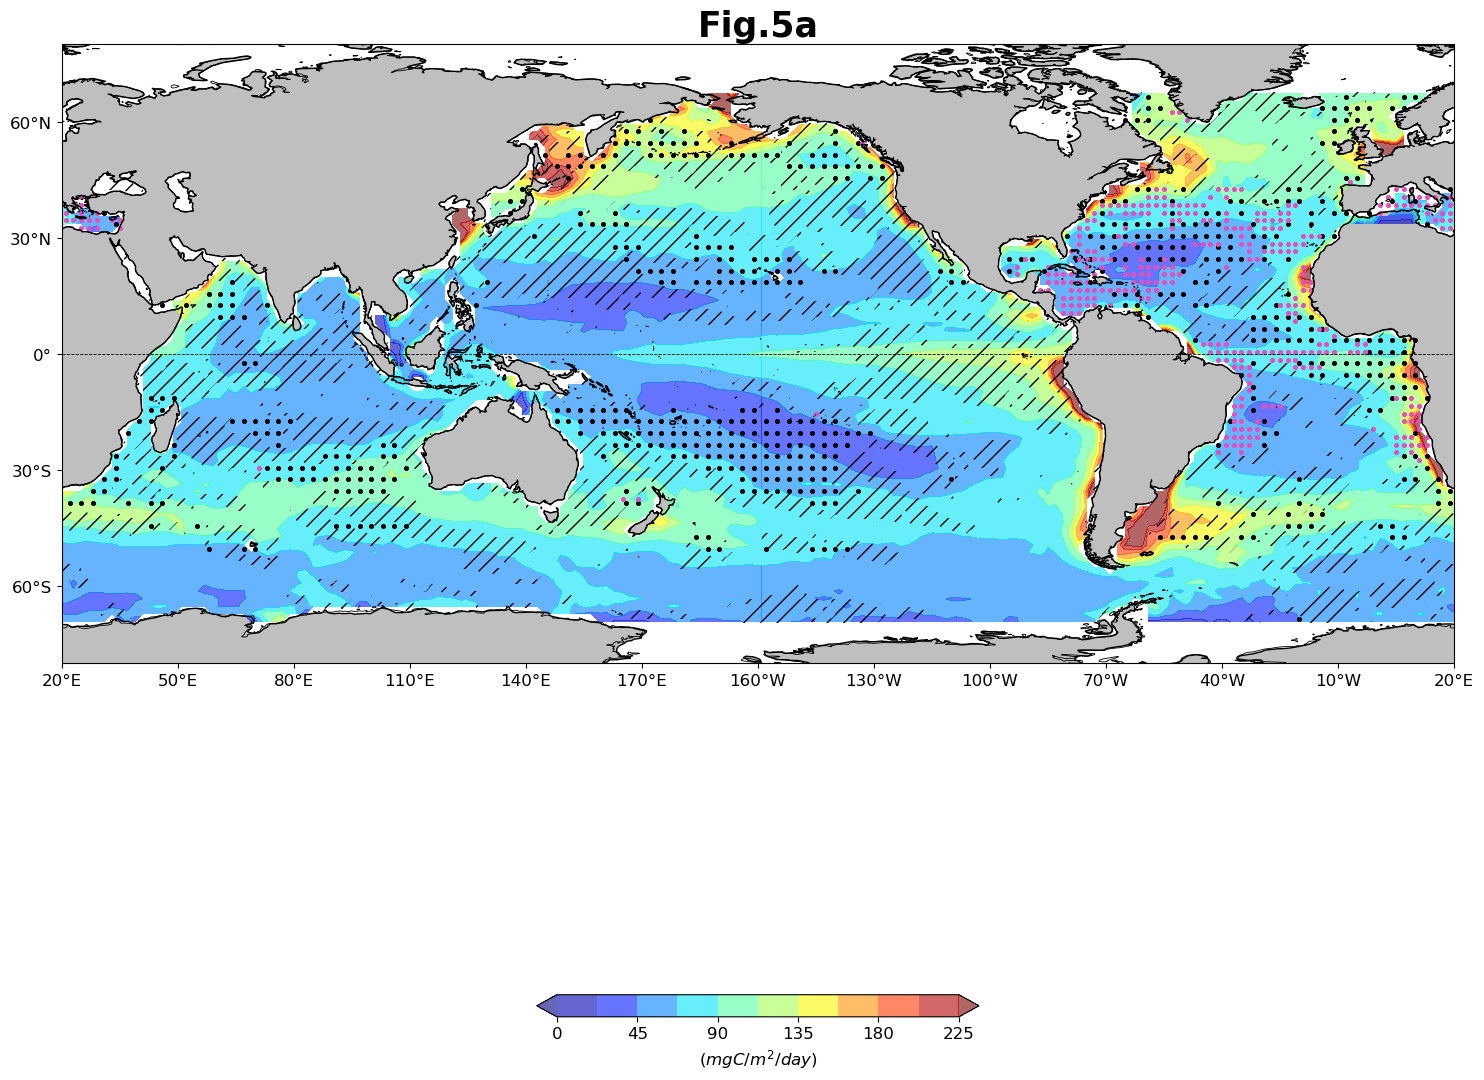

In [6]:
###### plot overlap
lon2d,lat2d=np.meshgrid(cycle_lon,lat)
lon2d_2,lat2d_2=np.meshgrid(cycle_lon_2,lat_2)
fig=plt.figure(figsize=(15, 23))
plt.rcParams['font.size'] = '12'  

box=[-180,180,-90,90]  
scale='50m'
xstep,ystep=30,30
proj=ccrs.PlateCarree(central_longitude=200)
ax2=plt.axes(projection=proj) 
ax2.plot([-180,180],[0,0],'--',linewidth=0.6,transform=proj,color='black')
ax2.add_feature(cfeature.LAND, facecolor='0.75')
ax2.add_feature(cfeature.COASTLINE, facecolor='0.75') 
ax2.coastlines(scale,linewidth=0.6) 
ax2.set_xticks(np.arange(box[0], box[1] + xstep, xstep), crs=proj)
ax2.set_yticks(np.arange(box[2], box[3] + ystep, xstep), crs=proj)
lon_formatter = LongitudeFormatter(zero_direction_label=False)  
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter) 
ax2.set_extent([-180,180,-80,80],crs=proj)

#### plot contour lines
interval=np.arange(0,226,22.5)
cb1=ax2.contourf(lon2d_2,lat2d_2,tot_ex,interval,cmap='jet',alpha=0.6,extend='both',transform=proj)  
    
levels = [0.5, 1.5]
cb2=ax2.contourf(lon2d,lat2d,(exposure_single_emergence_flag),(0,1),hatches=['//'],linewidth=1,cmap=new_whites,alpha=0,transform=proj)

levels = [1,2,3]
row, col = np.where(exposure_double_emergence_flag_reduce == 2)  #insignificant points
lats=lat[row]
lons=cycle_lon[col]
cb3=ax2.scatter(lons, lats, transform=proj, s=7, color='black') # plot high exposure regions with dots (double CIDs)

levels = [2,3,4]
row, col = np.where(exposure_triple_emergence_flag_reduce == 3)  #insignificant points
lats=lat[row]
lons=cycle_lon[col]
cb4=ax2.scatter(lons, lats, transform=proj, s=7,color='#e450bb') # plot high exposure regions with dots (triple CIDs)

#### set colorbar
cbar1=fig.colorbar(cb1,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.01)
cbar1.set_label(r'$(mgC/m^2/day)$', size=12, fontweight='bold', color='k')
plt.title('Fig.5a',fontdict={'weight':'bold','size':25})
fig.tight_layout()

plt.savefig('./Fig5a.pdf', dpi=750, bbox_inches='tight')
plt.show()